# Iniciación en Python con Aplicaciones en Aceración (module 02)

**Dr. Edgar Ivan Castro Cedeño**

[edgar.castro@cinvestav.mx](mailto:edgar.castro@cinvestav.mx)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.desulf as desulf # funciones propias
import src.sulfideCapacityModels as cS
from scipy.integrate import solve_ivp

# 4. Cálculo de la tasa de desulfuración

## 4.1 Ecuación diferencial de la tasa de desulfuración

La ecuación de diferencial de primer orden que se muestra debajo, permite estimar el progreso de la desulfuración de un baño de acero, considerando que al mismo tiempo que el azufre es removido del metal, el contenido de azufre en la escoria aumenta.


$$\frac{d[\%S]}{dt} = -k_{S,emp} \left([\%S] \left(1 + \frac{1}{\frac{M_{sl}}{1000} L_s} \right) - \frac{[\%S_0]}{\frac{M_{sl}}{1000} L_s}\right) $$


donde:

- $k_{S, emp}$: constante de desulfuración empírica que caracteriza el nivel de agitación en el baño y la extensión del área de contacto entre el metal y la escoria

- $[\%S]$: contenido de azufre en el metal.

- $[\%S_0]$: contenido de azufre inicial.

- $M_{sl}$: masa de escoria, en kg/ton.

- $L_S$: coeficiente de reparto de azufre.

In [2]:
def analytic(t:float, ks, wS0, Msl, Ls) -> float:
    B = ks*t
    Y = Msl/1000 * Ls
    A = (1-np.exp(-B-B/Y)) / (1+1/Y)
    return wS0 * (1 - A)

## 4.2 Resolución numérica de la ecuación diferencial

Se utiliza la función `solve_ivp()`, incluida en la librería `scipy.integrate` para efectuar la resolución numérica de la ecuación diferencial planteada en la función `desulfRate`.

In [3]:
# definir tiempos para integración y constantes
ks = 1e-3 # constante de desulfuración, [1/s]
wS0 = 0.020 #valor inicial de azufre, [wt%]
Msl = 20 # masa de escoria, kg/ton
Ls = 50 # coeficiente de reparto

In [4]:
# definir tiempos para integración y constantes
ks = 1e-3 # constante de desulfuración, [1/s]
wS0 = 0.020 #valor inicial de azufre, [wt%]
Msl = 10 # masa de escoria, kg/ton
Ls = 450 # coeficiente de reparto

# resolver la ecuacion diferencial
teval = np.linspace(0, 3600, 121)
sol1 = solve_ivp(
    desulf.desulfRate,
    t_span = (teval[0], teval[-1]),
    y0 = [wS0],
    args=(ks, wS0, Msl, Ls),
    t_eval = teval
)
# ver el objeto `sol` que contiene la solución
print(sol1)

analy = analytic(teval, ks, wS0, Msl, Ls)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.000e+01 ...  3.570e+03  3.600e+03]
        y: [[ 2.000e-02  1.941e-02 ...  3.846e-03  3.838e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 50
     njev: 0
      nlu: 0


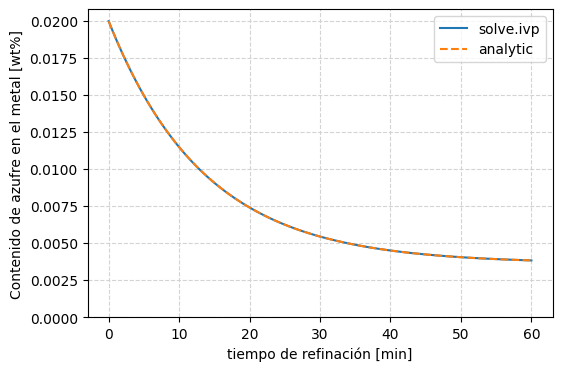

In [5]:
# graficando los resultados
fig, ax = plt.subplots(figsize=(6, 4))


# perfil de desulfuracion 1
t = sol1.t/60 # tiempo,[min]
wS = sol1.y[0] # azufre al tiempo t, [wt%]
ax.plot(t, wS, label='solve.ivp')

ax.plot(teval/60, analy, ls='--', label='analytic')

ax.set_xlabel("tiempo de refinación [min]")
ax.set_ylabel("Contenido de azufre en el metal [wt%]")

ax.grid(ls='--', color='lightgray')
ax.legend()

ax.set_ylim(0,)

plt.show()

## 4.3 Refinación del modelo

Hasta el momento, se ha resuelto la ecuación diferencial considerando que los parámetros, $k_{S,emp}$, y $L_S$, fueron determinados previamente por el utilizador.

$$\frac{d[\%S]}{dt} = -k_{S,emp} \left([\%S] \left(1 + \frac{1}{\frac{M_{sl}}{1000} L_s} \right) - \frac{[\%S_0]}{\frac{M_{sl}}{1000} L_s}\right) $$

### 4.3.1 Cálculo fino del coeficiente de reparto de azufre

El coeficiente de reparto de azufre está definido por la ecuación:

$$\log L_S = \underbrace{\log C_S -\frac{935}{T} + 1.375}_{\log C_S'} + \log f_S - \log h_O$$

El cálculo del término $\log C_S$ se puede llevar a cabo con alguno de los siete (7) modelos implementados en `sulfideCapacityModels.py`.

### 4.3.2 Cálculo fino de la constante de desulfuración

**Constante de desulfuración**

La constante de desulfuración, $k_S$ es proporcional a la potencia de agitación específica en la olla de acero, $\dot{\varepsilon}$.

$$
\begin{matrix}
k_{S}\,[\mathrm{min^{-1}}]  = 0.013\left(\dot{\varepsilon}\right)^{0.25} & \forall & \dot{\varepsilon} < [\mathrm{60\,W.ton^{-1}]} \\
k_{S}\,[\mathrm{min^{-1}}]  = 8\times10^{-6}\left(\dot{\varepsilon}\right)^{2.1} & \forall & \dot{\varepsilon} \ge [\mathrm{60\,W.ton^{-1}]} \\
\end{matrix}
$$

Esta correlación está implementada en la función `desulf.ksCalc`.

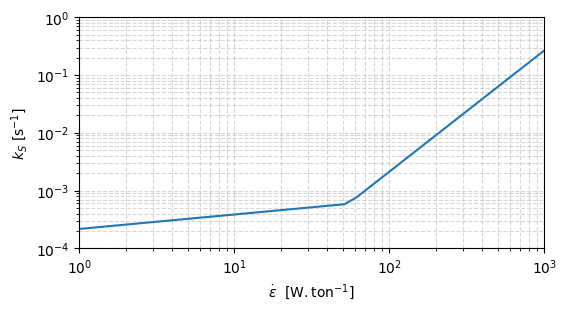

In [6]:
fig, ax = plt.subplots(figsize=(6, 3))

eps = np.linspace(1, 1000, 100)
kS = desulf.kSCalc(eps)
ax.plot(eps, kS)

# format
ax.set_xlabel(r'$\dot{\varepsilon}$  [$\mathrm{W.ton^{-1}}$]')
ax.set_xscale('log')
ax.set_xlim(1, 1000)
ax.set_ylabel(r"$k_S$ [$\mathrm{s^{-1}}$]")
ax.set_yscale('log')
ax.set_ylim(1e-4, 1)
ax.grid(ls='--', which='both', alpha=0.5)
plt.show()

**Potencia de agitación**

La potencia de agitación se puede estimar con la siguiente ecuación:

$$\dot{\varepsilon} = 14.23\left(\frac{\dot{V}T}{M}\right) \log \left(\frac{1+H}{1.48 P_0}\right)$$

donde:

- $\dot{\varepsilon}$: potencia de agitación, en $[\mathrm{W.ton^{-1}}]$.
- $\dot{V}$: Flujo volumétrico de gas de agitación, en $[\mathrm{Nm^3.min^{-1}}]$.
- $T$: Temperatura del baño, en $[\mathrm{K}]$.
- $M$: Masa del baño, en $[\mathrm{ton}]$.
- $H$: Profundidad de inyección de gas, en $[\mathrm{m}]$.
- $P_0$: Presión de gas en la superficie del baño, en $[\mathrm{atm}]$.

Esta correlación está implementada en la función `desulf.stirPowerCalc`.

## 4.4 Utilización del modelo refinado

In [7]:
### condiciones de proceso
V = 0.240 # flujo de gas [Nm3.min-1]
T = 1873 # Temperatura [K]
M = 150 # masa del baño de acero [ton]
H = 2 # profundidad de inyección de gas [m]
P0 = 1 # presión sobre el baño, [atm]

### condiciones del metal
wS0 = 0.020 #valor inicial de azufre, [wt%]
fS = 1 # coeficiente de actividad de azufre
aO = 0.0002 # actividad de oxígeno

### condiciones de la escoria
Msl = 10 # masa de escoria, kg/ton
slag =  {'Al2O3': 33,  # composición, wt%
         'CaO': 57, 
         'MgO': 5, 
         'SiO2': 5, 
         'FeO': 0, 
         'MnO': 0
}

In [8]:
### Cálculo de constante de desulfuración
eps = desulf.stirPowerCalc(V, T, M, H, P0) # potencia agitación [W.ton-1]
ks = desulf.kSCalc(eps)
print("ks = {:.4e} [s-1]".format(ks))

ks = 4.1209e-04 [s-1]


In [9]:
### Cálculo de basicidad óptica
l1 = cS.opticalBasicity(slag,T,False)
l1c = cS.opticalBasicity(slag,T,True)
print(f"Λ    : {l1:.4f}")
print(f"Λcorr: {l1c:.4f}")

Λ    : 0.7795
Λcorr: 0.7470


In [10]:
### Cálculo del coeficiente de reparto (distintos modelos)
tags = ["Gaye(1984)", "Sommerfield (1986)", "Young (1991)", "KTH (1999)", "Taniguchi (2009)", "Zhang (2013)", "Hao (2016)", "KTH (2018)"]
logCs_ = np.array([
    (cS.logCs_Gaye(slag, T)),       # 1984
    (cS.logCs_Sommer(slag, T)),     # 1986
    (cS.logCs_Young(slag, T)),      # 1991
    (cS.logCs_KTH(slag, T, False)), # 1999
    (cS.logCs_Tani(slag, T)),       # 2009
    (cS.logCs_Zhang(slag, T)),      # 2013
    (cS.logCs_Hao(slag, T)),        # 2016
    (cS.logCs_KTH(slag, T, True))   # 2018
])
Cs_ = np.power(10, logCs_)
logLs_ = desulf.logLs(Cs_, T, fS, aO)
Ls_ = np.power(10, logLs_)

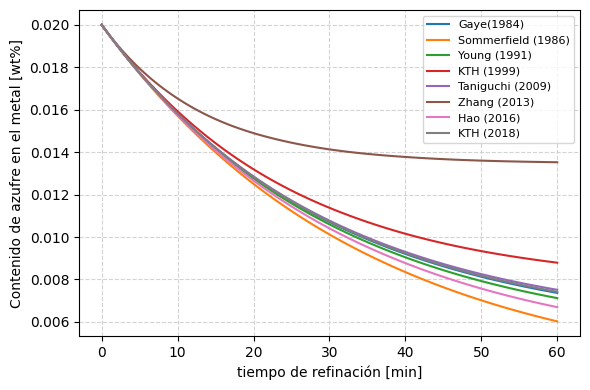

    Ls      log Cs       Model
264.4506 |  -2.1524 | Gaye(1984)
544.0107 |  -1.8392 | Sommerfield (1986)
293.9379 |  -2.1065 | Young (1991)
160.3613 |  -2.3697 | KTH (1999)
249.2456 |  -2.1781 | Taniguchi (2009)
 48.6767 |  -2.8874 | Zhang (2013)
360.7893 |  -2.0175 | Hao (2016)
258.7303 |  -2.1619 | KTH (2018)


In [11]:
### Cálculo de curva de desulfuración con distintos modelos
fig, ax = plt.subplots(figsize=(6, 4))

for tag, Ls in  zip(tags, Ls_):
# resolver la ecuacion diferencial
    teval = np.linspace(0, 3600, 121)
    sol3 = solve_ivp(
        desulf.desulfRate,
        t_span = (teval[0], teval[-1]),
        y0 = [wS0],
        args=(ks, wS0, Msl, Ls),
        t_eval = teval
    )
    # graficar resultados
    x = sol3.t/60 # tiempo,[min]
    y = sol3.y[0] # azufre al tiempo t, [wt%]
    ax.plot(x, y, label=tag)

ax.set_xlabel("tiempo de refinación [min]")
ax.set_ylabel("Contenido de azufre en el metal [wt%]")
ax.grid(ls='--', color='lightgray')
ax.legend(fontsize=8)
ax.grid(ls='--')
fig.tight_layout()
plt.show()

# imprimir Ls, log Cs de distintos modelos
print("    Ls      log Cs       Model")
print("======================================")
for tag, logCs, Ls in  zip(tags, logCs_, Ls_):
    print(f"{Ls:8.4f} | {logCs:8.4f} | {tag}")

## 4.5 Referencias

[Slag Atlas (1995)](https://www.stahleisen.de/product/slag-atlas/)  
ed. by VDEh. Verlag Stahleisen GmbH, Düsseldorf.

[The Making, Shaping and Treating of Steel: Steelmaking and Refining Volume (1998)](https://imis.aist.org/store/detail.aspx?id=PB-332)  
ed. by R. J. Fruehan, Association of Iron and Steel Engineers.

[Andersson M.A., Jönsson P.G., Nzotta M.M. (1999)](https://www.jstage.jst.go.jp/article/isijinternational1989/39/11/39_11_1140/_pdf)  
Application of the sulphide capacity concept on high-basicity ladle slags used in bearing-steel production.  
ISIJ international, 39(11), 1140-1149.

[Secondary Steelmaking: Principles and Applications (2000)](https://doi.org/10.1201/9781420042313)  
GHOSH, Ahindra.
CRC Press.

[Zhang G.H., Chou K.C., Pal U. (2013)](https://www.jstage.jst.go.jp/article/isijinternational/53/5/53_761/_article/-char/en)
Estimation of Sulfide Capacities of Multicomponent Slags using Optical Basicity  
ISIJ International 53, 761-767 (2013)